In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('../data/train.csv')
df = df.drop(columns=['Unnamed: 0'])

df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [3]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df["preprocessed_news"] = df["preprocessed_news"].apply(review_cleaning)


In [4]:
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_train = df.drop(['label'], axis = 1)
Y_train = df['label']

In [5]:
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
maxlen=256
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')


vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()


if not os.path.exists('../models/v2/rnn_tokenizer.pkl'):
    with open('../models/v2/rnn_tokenizer.pkl', 'wb') as arquivo:
        pickle.dump(train_tokenizer, arquivo)
if not os.path.exists('../models/v2/count_vectorizer.pkl'):
    with open('../models/v2/count_vectorizer.pkl', 'wb') as arquivo:
        pickle.dump(vectorizer, arquivo)

##### Logistic Regression


In [6]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,Y_train)
lr_classifier_train = round(lr_classifier.score(X_train, Y_train) * 100, 2)

with open('../models/v2/logisticRegression.pkl', 'wb') as arquivo:
    pickle.dump(lr_classifier, arquivo)

##### Multilayer perceptron (MLP)

In [7]:
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train,Y_train)
mlp_train = round(mlp.score(X_train, Y_train) * 100, 2)

with open('../models/v2/MLPClassifier.pkl', 'wb') as arquivo:
    pickle.dump(mlp, arquivo)


##### Multilayer perceptron (MLP) Com GridSearchCV

In [6]:
parameters = {'solver': ['sgd', 'lbfgs'],
              'hidden_layer_sizes':[10], 
              'random_state':[2],
              'activation': ['tanh', 'relu'],
              'max_iter': [10]
              }

clf = GridSearchCV(MLPClassifier(), parameters, cv=2)
clf.fit(X_train,Y_train)
mlpG_train = round(clf.score(X_train, Y_train) * 100, 2)


with open('../models/v2/MLPClassifierWithGridSearchCV.pkl', 'wb') as arquivo:
    pickle.dump(clf, arquivo)


c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\

#### Decision Tree

In [9]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train,Y_train)
decisionTree_train = round(clf.score(X_train, Y_train) * 100, 2)

with open('../models/v2/decisionTree.pkl', 'wb') as arquivo:
    pickle.dump(decisionTree, arquivo)

#### Passive Aggressive

In [12]:
passive = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
passive.fit(X_train,Y_train)
passive_train = round(passive.score(X_train, Y_train) * 100, 2)

with open('../models/v2/PassiveAggressiveClassifier.pkl', 'wb') as arquivo:
    pickle.dump(passive, arquivo)

#### RNN

In [ ]:
output_dim = 64
epochs = 60
batch_size = 32
tf.keras.backend.clear_session()

modelSimpleRNN = tf.keras.models.Sequential()
modelSimpleRNN.add(tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen))
modelSimpleRNN.add(tf.keras.layers.GRU(60, activation='tanh', return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.Conv1D(30, 3, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.LSTM(30, return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.SimpleRNN(3, activation='tanh'))
modelSimpleRNN.add(tf.keras.layers.Dropout(0.25))
modelSimpleRNN.add(tf.keras.layers.Dense(24, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))
modelSimpleRNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historySimpleRNN = modelSimpleRNN.fit(train_padded_seqeunces, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
rnn_train = round(historySimpleRNN.history['accuracy'][-1] * 100, 2)
modelSimpleRNN.save('../models/v2/modelo_rnn.keras')


#### LSTM (BI)

In [6]:
output_dim = 64
epochs = 60
batch_size = 32
tf.keras.backend.clear_session()

modelLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
historyLSTM = modelLSTM.fit(train_padded_seqeunces, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
LSTM_train = round(historyLSTM.history['accuracy'][-1] * 100, 2)
modelLSTM.save('../models/v2/modelLSTM.keras')


Epoch 1/60
130/130 [==============================] - 32s 208ms/step - loss: 0.5946 - accuracy: 0.8394 - val_loss: 0.2183 - val_accuracy: 0.9132
Epoch 2/60
130/130 [==============================] - 23s 176ms/step - loss: 0.1978 - accuracy: 0.9469 - val_loss: 0.4495 - val_accuracy: 0.9154
Epoch 3/60
130/130 [==============================] - 23s 174ms/step - loss: 0.0821 - accuracy: 0.9783 - val_loss: 0.2708 - val_accuracy: 0.9436
Epoch 4/60
130/130 [==============================] - 23s 175ms/step - loss: 0.0457 - accuracy: 0.9928 - val_loss: 0.2585 - val_accuracy: 0.9414
Epoch 5/60
130/130 [==============================] - 23s 174ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.4196 - val_accuracy: 0.9349
Epoch 6/60
130/130 [==============================] - 23s 175ms/step - loss: 0.0128 - accuracy: 0.9993 - val_loss: 0.2334 - val_accuracy: 0.9610
Epoch 7/60
130/130 [==============================] - 22s 173ms/step - loss: 0.0125 - accuracy: 0.9990 - val_loss: 0.2052 - val_ac

## Test

In [2]:
with open('../models/v2/rnn_tokenizer.pkl', 'rb') as arquivo:
    tokenizer = pickle.load(arquivo)
with open('../models/v2/count_vectorizer.pkl', 'rb') as arquivo:
    vectorizer_test = pickle.load(arquivo)

In [4]:
maxlen=256

df_test = pd.read_csv('../data/test.csv')
df_test = df_test.drop(columns=['Unnamed: 0'])

ParserError: Error tokenizing data. C error: Expected 3 fields in line 1153, saw 8


In [27]:
maxlen=256

df_test = pd.read_csv('../data/test.csv', encoding='ISO-8859-1')
df_test = df_test.drop(columns=['Unnamed: 0'])

stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(remover_stop_words)
df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(review_cleaning)

df_test['label'] = df_test.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_test = df_test.drop(['label'], axis = 1)
Y_test = df_test['label']

X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

X_test = vectorizer_test.transform(X_test).toarray()

In [28]:
with open('../models/v2/logisticRegression.pkl', 'rb') as arquivo:
    lr_classifier = pickle.load(arquivo)
with open('../models/v2/MLPClassifier.pkl', 'rb') as arquivo:
    mlp = pickle.load(arquivo)
with open('../models/v2/MLPClassifierWithGridSearchCV.pkl', 'rb') as arquivo:
    mlpG = pickle.load(arquivo)
with open('../models/v2/decisionTree.pkl', 'rb') as arquivo:
    decisionTree = pickle.load(arquivo)
with open('../models/v2/PassiveAggressiveClassifier.pkl', 'rb') as arquivo:
    passive = pickle.load(arquivo)
    
rnn = load_model('../models/v2/modelo_rnn.keras')
modelLSTM = load_model('../models/v2/modelLSTM.keras')


##### Logistic Regression


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       607
           1       0.98      0.95      0.96       548

    accuracy                           0.96      1155
   macro avg       0.96      0.96      0.96      1155
weighted avg       0.96      0.96      0.96      1155



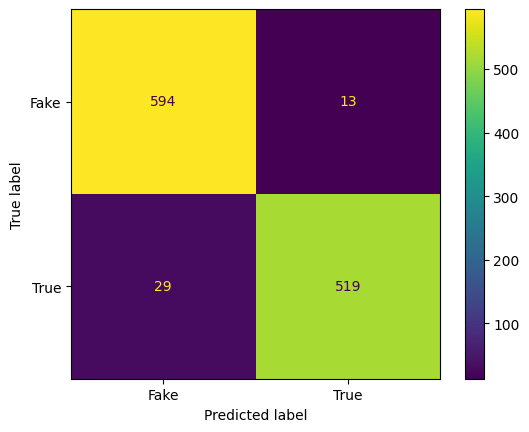

In [29]:
y_test_pred = lr_classifier.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
lr_classifier_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)
cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()



##### Multilayer perceptron (MLP)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       607
           1       0.96      0.89      0.92       548

    accuracy                           0.93      1155
   macro avg       0.93      0.93      0.93      1155
weighted avg       0.93      0.93      0.93      1155



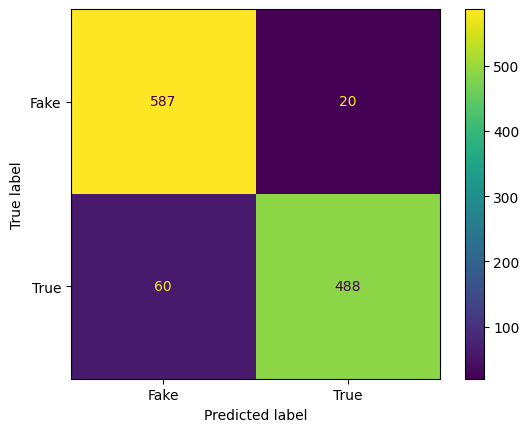

In [30]:
y_test_pred = mlp.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlp_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


##### Multilayer perceptron (MLP) Com GridSearchCV

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       607
           1       0.97      0.95      0.96       548

    accuracy                           0.96      1155
   macro avg       0.96      0.96      0.96      1155
weighted avg       0.96      0.96      0.96      1155



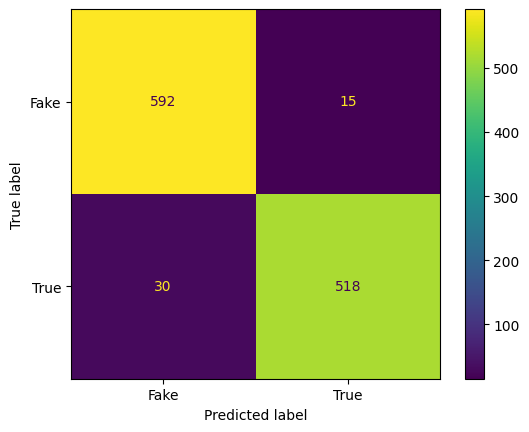

In [31]:

y_test_pred = mlpG.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlpG_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

    

#### Decision Tree

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       607
           1       0.90      0.89      0.89       548

    accuracy                           0.90      1155
   macro avg       0.90      0.90      0.90      1155
weighted avg       0.90      0.90      0.90      1155



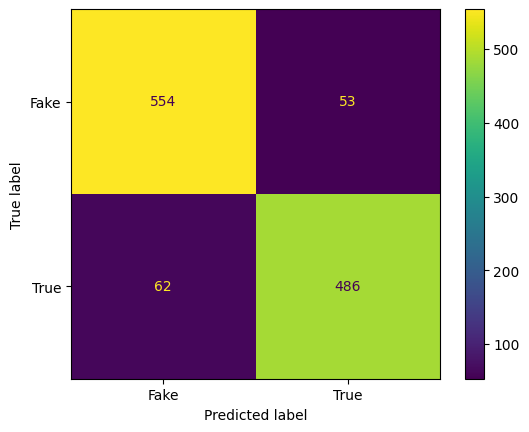

In [32]:
y_test_pred = decisionTree.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
decisionTree_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### Passive Aggressive

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       607
           1       0.90      0.89      0.89       548

    accuracy                           0.90      1155
   macro avg       0.90      0.90      0.90      1155
weighted avg       0.90      0.90      0.90      1155



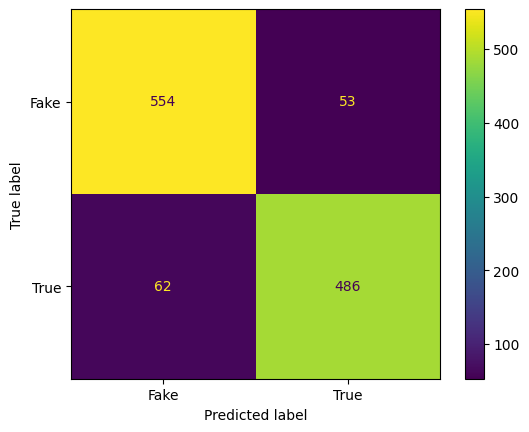

In [33]:
x_test_pred = passive.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
passive_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### RNN

37/37 [==============================] - 2s 40ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       607
           1       0.97      0.89      0.92       548

    accuracy                           0.93      1155
   macro avg       0.94      0.93      0.93      1155
weighted avg       0.93      0.93      0.93      1155



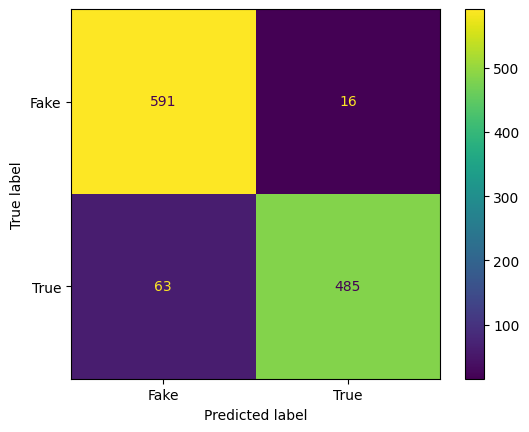

In [34]:

y_test_pred = rnn.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
rnn_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### LSTM(BI)

37/37 [==============================] - 3s 45ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       607
           1       0.94      0.92      0.93       548

    accuracy                           0.93      1155
   macro avg       0.93      0.93      0.93      1155
weighted avg       0.93      0.93      0.93      1155



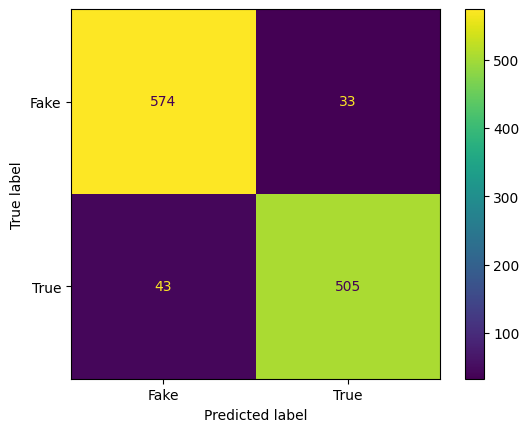

In [35]:

y_test_pred = modelLSTM.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
lstm_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


### Comparando Modelos Diferentes

model = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'MLPClassifier',
        'MLPClassifier with grid',
        'PassiveAggressiveClassifier',
        'RNN',
        'RNN LSTM(BI)'
    ],
    'Training Accuracy': [
        lr_classifier_train, decisionTree_train,
        mlp_train,mlpG_train, passive_train,rnn_train,lstm_train
    ],
    'Model Accuracy Score': [
        lr_classifier_acc, decisionTree_acc,
        mlp_acc, mlpG_acc, passive_acc,rnn_acc,lstm_acc
    ]
})

In [36]:
model = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'MLPClassifier',
        'MLPClassifier with grid',
        'PassiveAggressiveClassifier',
        'RNN',
        'RNN LSTM(BI)'
    ],
    'Model Accuracy Score': [
        lr_classifier_acc, decisionTree_acc,
        mlp_acc, mlpG_acc, passive_acc,rnn_acc,lstm_acc
    ]
})

In [37]:
model = model.sort_values('Model Accuracy Score',ascending=False)
model

,Model,Model Accuracy Score
0,Logistic Regression,96.36
3,MLPClassifier with grid,96.10
6,RNN LSTM(BI),93.42
5,RNN,93.16
2,MLPClassifier,93.07
1,Decision Tree,90.04
4,PassiveAggressiveClassifier,90.04
